## Project 3 Ferromagnetism

Due Wed Nov 17, 9am

Objective: Explore the Curie temperature and the Ising model of Ferromagnetism
See the pdf instructions on Canvas




In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import numba as nb
import matplotlib.animation as animation
from IPython.display import HTML


"""
This program explores the Ising model of Ferromagnetism to estimate the Curie
Temperature and observe the evolution of some NxN configuration of electrons
at certain temperatures.
Each electron is defined as either a 1 or a -1. This represents the spin state
the electron. Much of the calculation is based around the energy of the system.

The energy of a configuration is found by multiplying each electron by its
vertical and horizontal neighbours (not diagonal), and then summing the energy
of each electron. Based on this concept we design a function that randomly
switches the spin of an electron. Based on the resulting change in energy of
thesystem along with the temperature of the system, the probability of this
switchoccuring is calculated and then the switch either occurs or is passed by.
With this method, we can see how a evolves at some temperature and after
600 000switch attempts, we can find the magnetic moment by summing all the
electrons'spins.
With these we can plot the magnetic moment vs temperature to determine the
Curie temperature; the temperature at which a substance loses its
ferromagnetism. Finally, with the same function, we can create an animation
to watch how a system evolves over the 600 000 itterations.
"""

# CONSTANTS =============
N = 50  # system dimension (one axis)
TAF = np.array([0.01, 0.1, 1, 2, 3, 4, 5, 10, 100])  # array of temperatures
sgm = np.random.choice(np.array([-1, 1]), (N, N))  # initial spin configuration
itr = 600000  # iterations

# FUNCTIONS ============


def energy(array):
    """
    This calculate the total energy of a given configuration of electrons
    represented by ones and negative ones.
    It uses covolve to find the sum of each electron multiplied by its
    neighbour    to the right and below to find energy of individual
    electron. Only uses two neighbours to avoid double counting. Finally
    sums each energy state for total energy.

    Inputs:
        array (numpy array of integers): configuration of electrons with
            positive of negative spin represented by 1 and -1 respectively
    Outputs:
        tot_energy: the negative sum of each electron multiplied by its
            4 neighbours - represents the total energy of a configuration
            of electrons' spins in a system
    """
    # guide for convolve to follow
    map1 = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]])
    # finds energy of each each electron
    arr = -array*convolve(array, map1, mode="wrap")
    tot_energy = arr.sum()
    return tot_energy


@nb.njit(nopython=True, nogil=True)  # numba is used as it improves runtime
def evolve(iters, T, save_ani=False):
    """
    Finds the evolution of the configuration of a randomly generated initial
    confiuration of electrons over a given number of iterations at some
    temperature. It does this by using the deltaE function to try to achive
    the lowest possible total energy, i.e. the most stable arrangement.

    Inputs:
        iters (integer): Iterations; the number of times deltaE is called
        T (float): The temperature of the sytem
        save_ani (Boolean): Decides whether or not every 2000th configuration
            will be saved. Set to True for animation purposes

    Outputs:
        mag_moment (integer): The magnetic moment of the system configuration
            after given number of iterations. Found by summing all elements of
            the array.
        imgs (list of numpy arrays): When save_ani = False this list is empty
            When save_ani = True this list contains the configuration at every
            2000th step in the iteration which allows visualization of the
            evolution of the system.
    """
    sgm_0 = np.random.choice(np.array([-1, 1]), (N, N))  # intial configuration
    # array for probabilty of energy change acceptance, used in deltaE
    probs = np.empty(9)
    probs[4] = np.exp(-4/T)  # probability for energy change of 4, index with 4
    probs[8] = np.exp(-8/T)  # probability for energy change of 8, index with 8

    imgs = []
    for i in range(iters):
        if i % 2000 == 0:  # saves every 2000th array
            if save_ani:  # checks if saving arrays is needed
                imgs.append(sgm_0.copy())
        deltaE(sgm_0, T, probs)  # progresses the evolution of the system
    mag_moment = sgm_0.sum()  # sums final configuration of electrons
    return mag_moment, imgs


@nb.njit(nopython=True, nogil=True)  # numba is used as it improves runtime
def deltaE(arr, T, Ps):
    """
    Randomly selects an index of the given system and calculates the change
    in energy of the sytem based on flipping the spin (sign) of the electron.
    This is achieved by finding the change in energy of the electron that would
    be flipped as it corresponds to the change in energy of the entier system
    as it is the only electron changing state.
    Based on the calculated change in energy and the given temperature, it
    decides whether this electron flipping is probable. If the change in energy
    is negative it is accepted. If it is positve, it's probablity is calculated
    using the given temperature and is compared to a randomly generated number
    to decide if it is accepted.

    Inputs:
        arr (numpy array of itegers): configuration of electrons' spins in a
            system
        T (float): temperature of the system
        Ps (numpy array if floats): The probabilities for acceptance of energy
            changes of 4 and 8

    Outputs:
        None - updates the given array in place
    """
    x = np.random.randint(0, N)  # random x coordinate
    y = np.random.randint(0, N)  # random y coordinate
    xp1 = (x + 1) % (N)  # for when x is at right edge of system
    yp1 = (y + 1) % (N)  # for when y is at bottom edge of system
    # energy of randomly indexed electron from neighbouring electrons
    val = arr[x, y]*(arr[xp1, y] + arr[x, yp1] + arr[x-1, y] + arr[x, y-1])
    # change in E is always -2 times the initial energy of the indexed electron
    # it becomes positive from the negative in the equation
    val *= 2
    if val <= 0:  # accepts negative and neutral energy changes
        arr[x, y] *= -1
    else:  # decides whether to accept positive energy changes
        rn = np.random.uniform(0, 1)
        # indexes array made in line 69 to use relevant probability
        if Ps[val] > rn:  # compares probability to rn to decide on acceetance
            arr[x, y] *= -1


# FUNCTION USAGE ===========

E_0 = energy(sgm)
print("The total energy of the initial configuration is {:n}".format(E_0))

The total energy of the initial configuration is 36


In [1]:
# Calculate M vs T and plot it here
"""
This cell computes the asolute value of the magnetic moment of a system
after 'itr' steps of evolution using the evolve function from the
previous cell. It does this five times for each temperature in TAF and
selects the maximum magnetic moment for each. It then plots these
maximum values vs temperature. From this we can see at what temperature
an object loses it's magnetism and thus determine the Curie Temperature.
"""


max_mms = np.empty(len(TAF))  # array for max magnetic moment storage
for t in range(len(TAF)):
    mmAF = np.empty(5)  # Array for 5 magnetic moments for each temperature
    for n in range(5):
        # save_ani kept false as images aren't needed
        mm, imgs = evolve(itr, TAF[t])
        mmAF[n] = abs(mm)   # records absolute value of magnetic moment
    max_mms[t] = np.amax(mmAF)  # finds maximum Magnetic moment and records it


# PLOTTING =============

plt.plot(TAF, max_mms, "bo--")
plt.xscale('log')
plt.xlabel("Temperature")
plt.ylabel("Magnetic Moment (maximum of five results)")
plt.title("Curie Temperature Visualization")
plt.show()

# formatted like this to avoid a line that is too long
print("The Curie temperature for this substance is "
      "approximately {:3.3}".format(TAF[5]))

NameError: name 'np' is not defined

In [3]:
# Generate 3rd animation here
"""
This cell generates an animation depicting the evolution of a randomly
generated system of electrons over 'itr' steps at a temperature of 0.1.
Only every 2000th configuration is taken so the animation is not
excessively long.
"""


fig = plt.figure()  # base for animation
# produces list of configurations for animations (grids)
mm, grids = evolve(itr, TAF[1], True)
meshes = []  # list for coloured configurations

for grid in grids:  # this converts configurations to image format
    meshes.append((plt.pcolormesh(grid, vmin=-1, vmax=1), ))

meshes_animation = animation.ArtistAnimation(fig, meshes,
                                             interval=50, repeat=False)

# repeat is ignored with the file output we produce here, but can be
# useful for other output forms.

# Save to a file:
meshes_animation.save('0.1degrees.webm', extra_args=['-vcodec', 'libvpx'])

plt.close()  # this prevents a stray plot from appearing.
del meshes  # these two lines allow the memory held by images to be released.
del meshes_animation

HTML('<video controls autoplay>'
     '<source src="0.1degrees.webm" type="video/webm"></video>')

In [4]:
# Generate 2nd animation here
"""
This cell generates an animation depicting the evolution of a randomly
generated system of electrons over 'itr' steps at a temperature of 2.5.
Only every 2000th configuration is taken so the animation is not
excessively long.
"""


fig = plt.figure()  # base for animation
# produces list of configurations for animations (grids)
mm, grids = evolve(itr, 2.5, True)
meshes = []  # list for coloured configurations

for grid in grids:  # this converts configurations to image format
    meshes.append((plt.pcolormesh(grid, vmin=-1, vmax=1), ))

meshes_animation = animation.ArtistAnimation(fig, meshes,
                                             interval=50, repeat=False)

# Save to a file:
meshes_animation.save('2.5degrees.webm', extra_args=['-vcodec', 'libvpx'])

plt.close()  # this prevents a stray plot from appearing.
del meshes  # these two lines allow the memory held by images to be released
del meshes_animation

HTML('<video controls autoplay>'
     '<source src="2.5degrees.webm" type="video/webm"></video>')

In [5]:
# Generate 3rd animation here
"""
This cell generates an animation depicting the evolution of a randomly
generated system of electrons over 'itr' steps at a temperature of 100.
Only every 2000th configuration is taken so the animation is not
excessively long.
"""

fig = plt.figure()  # base for animation
# produces list of configurations for animations (grids)
mm, grids = evolve(itr, TAF[8], True)
meshes = []  # list for coloured configurations

for grid in grids:  # this converts configurations to image format
    meshes.append((plt.pcolormesh(grid, vmin=-1, vmax=1), ))

meshes_animation = animation.ArtistAnimation(fig, meshes,
                                             interval=50, repeat=False)

# repeat is ignored with the file output we produce here, but can be
# useful for other output forms.

# Save to a file:
meshes_animation.save('100degrees.webm', extra_args=['-vcodec', 'libvpx'])

plt.close()  # this prevents a stray plot from appearing.
del meshes  # these two lines allow the memory held by images to be released.
del meshes_animation

HTML('<video controls autoplay>'
     '<source src="100degrees.webm" type="video/webm"></video>')

# Acknowledgements
Please describe the role of **anyone other than yourself** who contributed to the work shown in this notebook. 

Its ok to get help from us and classmates! Please get in the habit of acknowledging such contributions.

If you want to refer to a classmate, please use only their cocalc email-id and not their name - or you could just say something like: "a classmate gave me the idea to use xxx feature to solve yyy problem."

 - Grey helped me figure out the function to calculate the energy of a configuration. ie. helped me get it together for the start of the project.
 - Grey helped me with making my code more compact, and using evolve to call deltaE with the save image check instead of having
redundant functions

 - Guillermo (guillermo.ecab@gmial.com) introduced me to numba which allows my code to run much faster

 - Guillermo showed me convolve to effeciently calculate the energy of a configuration

 - For the animations I used the code from the project outline and made adjustments so it fit my work

All solution code for the main project question should appear above this cell.
Project extensions should appear in the cell below.

In [6]:
# OPTIONAL project extension (which can call functions in your code above if desired) here.
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

# Extension Description

Please describe any new language features or project extension you have implemented in this cell.



Code executes - grader use only

YOUR ANSWER HERE

In [12]:
# pep8 returns warnings or errors
nb_name = "project3.ipynb"
cells_to_check = []
cells_to_exclude = ['cell-style', 'cell-optimization0']
stop_at = ['cell-extension']

# check_style.py uses cells_to_check and nb_name
%run -i check_style2.py


checking cell: cell-proj3-1
checking cell: cell-proj3-2
checking cell: cell-proj3-3
checking cell: cell-proj3-4
checking cell: cell-proj3-5


<Figure size 864x504 with 0 Axes>

Results Grade - grader use only

YOUR ANSWER HERE

Comments, naming, readability - grader use only

YOUR ANSWER HERE

Plots - grader use only

YOUR ANSWER HERE

Code compactness and organization - grader use only

YOUR ANSWER HERE

The total energy of the initial configuration is -72
Time for cell: cell-proj3-1 time: 0.01


/usr/local/lib/python3.8/dist-packages/numba/core/decorators.py:252: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


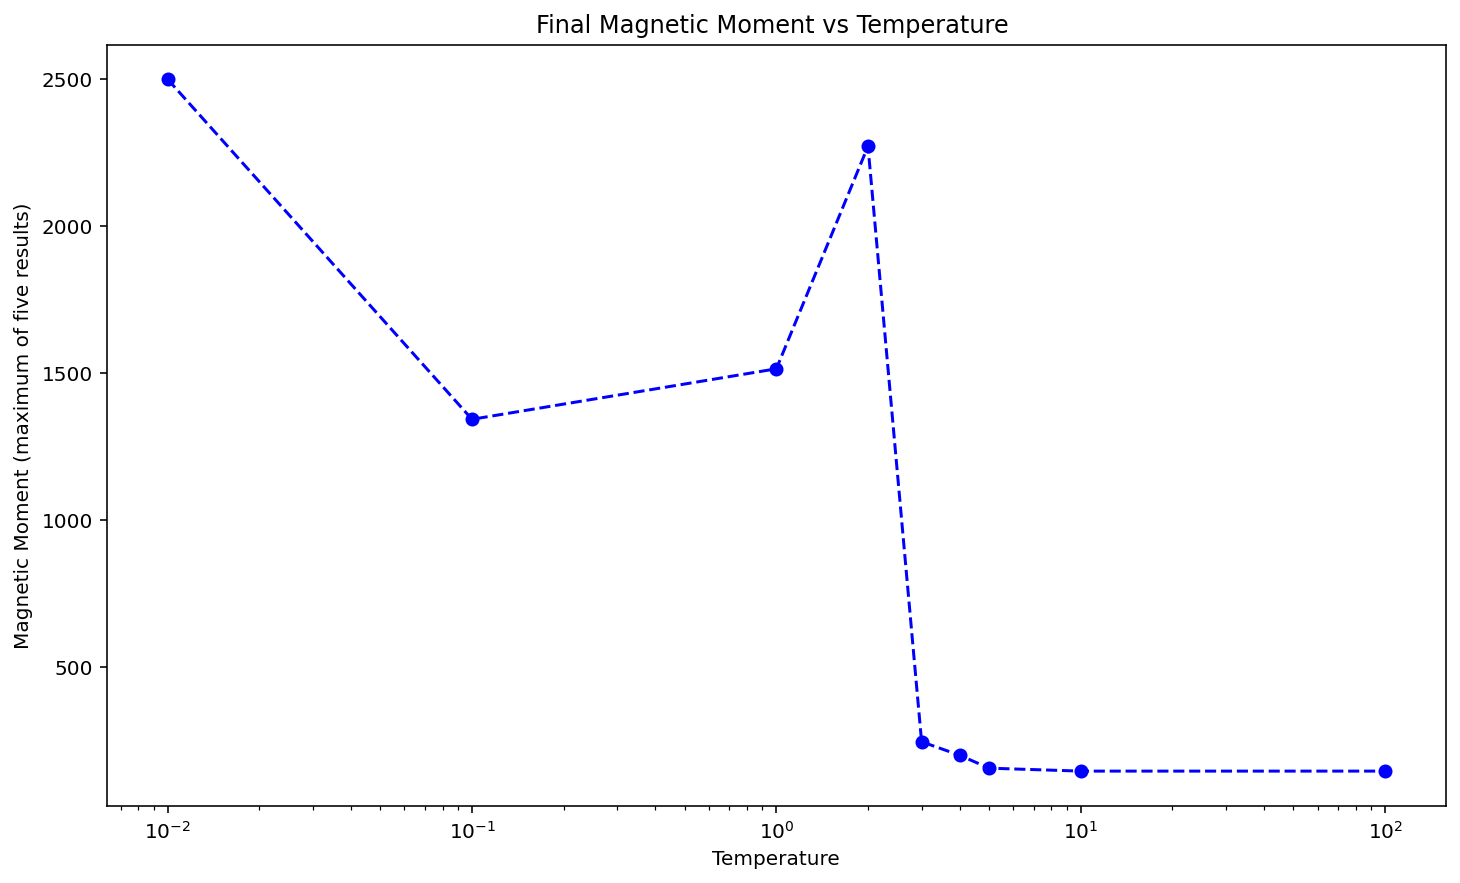

The Curie temperature for this substance is approximately 4.0
Time for cell: cell-proj3-2 time: 2.38


Time for cell: cell-proj3-3 time: 16.91


Time for cell: cell-proj3-4 time: 18.57


Time for cell: cell-proj3-5 time: 20.11
Total time: 57.98


<Figure size 864x504 with 0 Axes>

In [8]:
    # Code optimization/speed
cells_to_time = []
cells_to_exclude = ['cell-style', 'cell-optimization0']
stop_at = ['cell-extension']
# also uses nb_name
%run -i time_cells2.py

Code optimization/timing - grader use only

YOUR ANSWER HERE

New Functionality/Language features - grader use only

YOUR ANSWER HERE